# Table of contents:

1. [Introduction](#Introduction)
    * [Description of the data](#Data_outline)
    
    
2. [Part 1: Opening the data and reading it](#part_1)
3.[Part 2: Prepare the data for analysis](#part_2)
    * [Changing column names](#column_names)
    * [Checking for missing values and duplicates](#missing_values)
    * [Changing column datatypes](#column_datatypes)
    * [Creating date columns](#date_column)
4. [Part 3: Study and check the data](#part_3)
    * [3.1 How many events are in the logs?](#3.1)
    * [3.2 How many users are in the logs?](#3.2)
    * [3.3 What's the average number of events per user?](#3.3)
    * [3.4 What period of time does the data cover?](#3.4)
    * [3.5 Users in groups](#3.5)
5. [Part 4: Event Funnel](#4)
    * [Conclusion](#funnel_conclusion)
6. [Part 5: A/A/B test](#5)
    * [Conclusion](#5.1)

<a id=introduction></a>

# Introduction

I work at a startup that sells food products. I need to investigate user behavior for the company's app. First I'll study the sales funnel. I'll Find out how users reach the purchase stage. Then I'll look at the results of an A/A/B test. The designers would like to change the fonts for the entire app, but the managers are afraid the users might find the new design intimidating. I'll analyize the results, and write conclusions accordingly. 

<a id=Data_outline></a>

## Description of the data:


EventName — event name

DeviceIDHash — unique user identifier

EventTimestamp — event time

ExpId — experiment number: 246 and 247 are the control groups, 248 is the test group

<a id=part_1></a>

# Part 1: Opening the data and reading it

First, Let's import all the libaries:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import scipy.stats as stats
import math as mth
import pingouin as png

Let's read the dataframe:

In [2]:
try:
    data = pd.read_csv(r'C:\Users\nadav\OneDrive\מסמכים\Practicum100\databases\logs_exp_us.csv')
except:
    data = pd.read_csv('/datasets/logs_exp_us.csv')

Let's see the file:

In [3]:
data.head()

,EventName\tDeviceIDHash\tEventTimestamp\tExpId
0,MainScreenAppear\t4575588528974610257\t1564029...
1,MainScreenAppear\t7416695313311560658\t1564053...
2,PaymentScreenSuccessful\t3518123091307005509\t...
3,CartScreenAppear\t3518123091307005509\t1564054...
4,PaymentScreenSuccessful\t6217807653094995999\t...


We see we have a parsing problem. Let's re-read the file:

In [4]:
try:
    data = pd.read_csv(r'C:\Users\nadav\OneDrive\מסמכים\Practicum100\databases\logs_exp_us.csv', sep = '\s+')
except:
    data = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\s+')

In [5]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Thats better!

<a id=part_2></a>

# Part 2. Prepare the data for analysis

Let's study the general information on this dataframe:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


<a id=column_names></a>

We have some adjustments to do. Let's change our column names:

In [7]:
data.columns = ['event_name','user_id', 'timestamp', 'group']

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   timestamp   244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


<a id=missing_values></a>

Great! Let's check for missing values and duplicates:

In [9]:
data.isnull().sum()

event_name    0
user_id       0
timestamp     0
group         0
dtype: int64

In [10]:
data.duplicated().sum()

413

On the one hand, We have no missing values, but on the other hand, we have 413 duplicates! Let's check if they have anything in common:

In [11]:
data[data.duplicated()].head()

,event_name,user_id,timestamp,group
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248


Seems like they have nothing in common. Probably it's just a bug. Let's inform the developers and delete the duplicates:

In [12]:
data = data.drop_duplicates().reset_index(drop = True)

In [13]:
data.duplicated().sum()

0

Great! No duplicates. Let's check the 'expid' column for weird values:

In [14]:
data['group'].value_counts()

248    85582
246    80181
247    77950
Name: group, dtype: int64

<a id=column_datatypes></a>

The group sizes look good. Let's turn the column to categorical:

In [15]:
data['group'] = data['group'].astype('category')

Great! Let's check the event name and see if all values add up there:

In [16]:
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Looks like we can turn this into category too. Let's do that:

In [17]:
data['event_name'] = data['event_name'].astype('category')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   event_name  243713 non-null  category
 1   user_id     243713 non-null  int64   
 2   timestamp   243713 non-null  int64   
 3   group       243713 non-null  category
dtypes: category(2), int64(2)
memory usage: 4.2 MB


<a id=date_column></a>

Now, let's create a column for the date:

In [19]:
data['datetime'] = [dt.fromtimestamp(x) for x in data['timestamp']]

Let's create a new column only for dates:

In [20]:
data['date'] = data['datetime'].dt.date.astype('datetime64')

In [21]:
data['date']

0        2019-07-25
1        2019-07-25
2        2019-07-25
3        2019-07-25
4        2019-07-25
            ...    
243708   2019-08-08
243709   2019-08-08
243710   2019-08-08
243711   2019-08-08
243712   2019-08-08
Name: date, Length: 243713, dtype: datetime64[ns]

Looks good!

### Conclusion:

Let's summarize what we did in this part:
- We changed column names.
- We checked for missing values and found that we didn't have any.
- We found duplicates in the data and deleted them.
- We changed the datatypes of the 'event_name' and 'group' columns from 'object' to 'category'.
- We created 2 new columns: 'datetime' - The date and time of the event, 'date' the date of the event. 

---

<a id=part_3></a>

# Part 3. Study and check the data

<a id=3.1></a>

### 3.1 How many events are in the logs?

Let's check the total number of events we have:

In [22]:
event_num = len(data)
print(f'There are {event_num} events in total')

There are 243713 events in total


We have 243,713 events, a lot to work with.

<a id=3.2></a>

### 3.2 How many users are in the logs?

Let's check the number of users:

In [23]:
user_num = data['user_id'].nunique()
print(f'There are {user_num} users in total')

There are 7551 users in total


7551 users in total.

<a id=3.3></a>

### 3.3 What's the average number of events per user?

In [24]:
print(f'The average events per user is: {event_num / user_num}')

The average events per user is: 32.27559263673685


On average, each user does 32.275 actions on the website. This is quite a large number which is a good sign!

Let's check the distribution of the data:

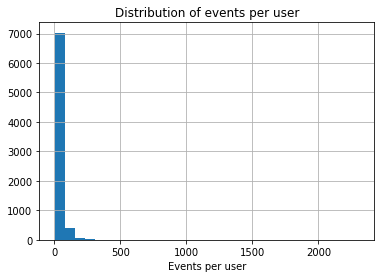

In [25]:
events_per_user = data.groupby('user_id', as_index = False).agg({'event_name':'count'})
events_per_user['event_name'].hist(bins = 30)
plt.title("Distribution of events per user")
plt.xlabel("Events per user");

It seems we have some big outlines! Let's check the mode of events per user:

In [26]:
event_med = events_per_user['event_name'].mode()[0]
print(f'The mode of events per user is: {event_med}')

The mode of events per user is: 5


We can see that most people did 5 events in our website. This isn't a very good sign and we should analyze why do most people not do a lot of actions. Maybe the time period is too small for customers to return.

<a id=3.4></a>

### 3.4 What period of time does the data cover?

Let's check the maximum and minimum dates:

In [27]:
data['date'].max()

Timestamp('2019-08-08 00:00:00')

In [28]:
data['date'].min()

Timestamp('2019-07-25 00:00:00')

We can see from this that our data covers a 2 week span: from the 25\07\2019 untill 08\08\2019. Let's check the ditribution of those dates:

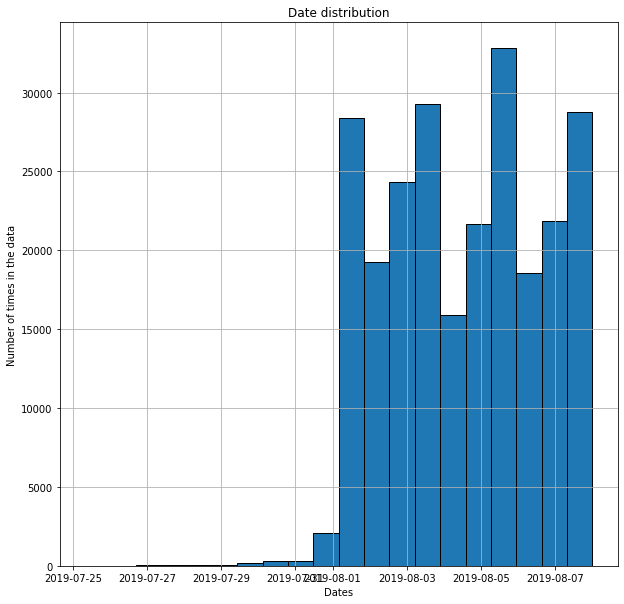

In [29]:
data['datetime'].hist(bins = 20,figsize = (10,10), edgecolor = 'black')
plt.title('Date distribution')
plt.xlabel('Dates')
plt.ylabel('Number of times in the data');

It looks like our data is not distributed right. Older events probably ended up in some users' logs for technical reasons, and this skewed the overall picture. Let's find the time where the data begins to even up:

In [30]:
data.groupby('date')['user_id'].count()

date
2019-07-25        9
2019-07-26       30
2019-07-27       55
2019-07-28      104
2019-07-29      181
2019-07-30      397
2019-07-31     1213
2019-08-01    35767
2019-08-02    35571
2019-08-03    33602
2019-08-04    32583
2019-08-05    36075
2019-08-06    36270
2019-08-07    31788
2019-08-08       68
Name: user_id, dtype: int64

We can see that the data we have is acctually a week period: from 01/08/2019 untill 07/08/2019. Let's filter our data accordingly:

In [31]:
filtered_data = data.loc[(data['date'] >= '2019-08-01') & (data['date'] <= '2019-08-07')]

Let's check how many events we lost in the filtered data:

In [32]:
new_event_num = len(filtered_data)
print("Amount of events lost in new data:",event_num - new_event_num)
print("The percentage of events lost in new data:{:.2%}".format((event_num - new_event_num) / event_num))

Amount of events lost in new data: 2057
The percentage of events lost in new data:0.84%


We lost 2057 events, which makes it 0.84% of the original data. Out of nearly 250,000 events, this is a very small portion. Let's check how many users we lost:

In [33]:
new_user_num = filtered_data['user_id'].nunique()
print("Number of users lost in new data:",user_num - new_user_num)
print("The percentage of users lost in new data:{:.2%}".format((user_num - new_user_num) / user_num))

Number of users lost in new data: 13
The percentage of users lost in new data:0.17%


We lost 13 users out of 7551, which makes it 0.17% of the old data. That is also a very small amount. We can say that the ratio of events per user is quite the same. 

<a id=3.5></a>

### 3.5 Users in groups

Let's check if we have users in all groups:

In [34]:
filtered_data.groupby('group')['user_id'].nunique()

group
246    2484
247    2517
248    2537
Name: user_id, dtype: int64

We can see we have unique users in each group. Let's check if there are any users that are in more than 1 group:

In [35]:
uniq_group_users = filtered_data.groupby('group')['user_id'].nunique().sum()
uniq_group_users - new_user_num

0

We see that the sum of all of the groups unique users equals the sum of all the experiments unique users. This means we don't have any user who is on both groups. We can go on to the analysis.

### Conclusion:

Let's summurize what we did in this part:
- We calculated the number of users, number of events and the number of events per user
- We checked the distribution of the data according to dates, and filtered the data accordingly.
- We checked how many users are in each data group and if there are any users on both groups.

We discovered that:
- Most users complete only 5 events on the website.
- The dates that we will work with only consist of a week: 01/08/19 - 07/08/2019.

<a id=4></a>

# Part 4: Event Funnel

Let's check our events and their frequency:

In [36]:
filtered_data['event_name'].value_counts()

MainScreenAppear           117850
OffersScreenAppear          46509
CartScreenAppear            42338
PaymentScreenSuccessful     33949
Tutorial                     1010
Name: event_name, dtype: int64

We can see we have 5 events: 1. Main screen 2.Offers screen 3.Cart screen 4. Payment successful screen 5.Tutorial

Let's check the number of users that did each event at least once:

In [37]:
users_per_event = filtered_data.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by = 'user_id',ascending = False).reset_index()
users_per_event.columns = ['event_name','number_of_users']
users_per_event

,event_name,number_of_users
0,MainScreenAppear,7423
1,OffersScreenAppear,4596
2,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540
4,Tutorial,843


Let's calculate the proportion of users that completed each event:

In [38]:
users_per_event['general_ratio'] = users_per_event['number_of_users'] / new_user_num
users_per_event['general_ratio'] = pd.Series(["{0:.2f}%".format(val * 100) for val in users_per_event['general_ratio']], index = users_per_event.index)
users_per_event

,event_name,number_of_users,general_ratio
0,MainScreenAppear,7423,98.47%
1,OffersScreenAppear,4596,60.97%
2,CartScreenAppear,3736,49.56%
3,PaymentScreenSuccessful,3540,46.96%
4,Tutorial,843,11.18%


We can see a few interesting things in the data: First, not all users came through the main screen. Some probably came from a different source. Next, a very small amount of people used the tutorial. Maybe it isn't that neccerery, or there are bugs in it. It looks like the regular funnel is: main screen, offers screen, cart screen, payment successful screen. The tutorial dosen't seem to be connected to our funnel, so we'll continue the calculations without it.

In [39]:
funnel = users_per_event.loc[0:3]

In [40]:
funnel

,event_name,number_of_users,general_ratio
0,MainScreenAppear,7423,98.47%
1,OffersScreenAppear,4596,60.97%
2,CartScreenAppear,3736,49.56%
3,PaymentScreenSuccessful,3540,46.96%


Let's plot our funnel graph:

In [54]:
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['number_of_users'],
    ))
fig.update_layout(title = 'Event funnel')
fig.write_html("index.html", include_plotlyjs='cdn')

Let's calculate the ratioof users that were lost on each stage in the funnel:

In [42]:
previous = funnel['number_of_users'][0]
funnel['stay_ratio'] = 0
for i in funnel.index:
    funnel['stay_ratio'][i] = "{:.2%}".format(funnel['number_of_users'][i] / previous)
    previous = funnel['number_of_users'][i]
funnel

,event_name,number_of_users,general_ratio,stay_ratio
0,MainScreenAppear,7423,98.47%,100.00%
1,OffersScreenAppear,4596,60.97%,61.92%
2,CartScreenAppear,3736,49.56%,81.29%
3,PaymentScreenSuccessful,3540,46.96%,94.75%


We can see that our main problem is getting people from the main screen to the offers screen: only 61% of people proceeded. Maybe the main page dosen't look appealing enough to users. This is definetly something we need to get into.

Let's check the share of users that go through the whole funnel:

In [43]:
"{:.2%}".format(funnel['number_of_users'][3] / funnel['number_of_users'][0])

'47.69%'

Only 47% completed the whole journey. This is a number we definetly can and should raise.

<a id=funnel_conclusion></a>

#### Conclusion

Let's sum up what we did in this stage:
- We sorted our events by frequency and checked the amount of users that did each event.
- We found the general ratio of users that did each event.
- We determined the regular customer funnel and calculated the share of users that proceed in each stage.
- We found the amount of users that completed the whole funnel

My analysis shows that:
- Not all of the users go through the funnel: We don't have 100% on the main page.
- The tutorial part is used by a small amount of users. 
- The stage with the lowest proceeding ratio is the Main page, with only 61% of it's visitors proceeding to the offers page.
- The ratio of people that complete the funnel is 47.69%

I can reccomend that:
- We check why people are not going through our main page.
- We check the tutorial page for any bugs.
- We try and improve our main page so that it will be appealing to more of the customers. Maybe changing the font will help.

<a id=5></a>

# Part 5: A/A/B test

Let's check the amount of users we have in each group:

In [44]:
filtered_data.groupby('group')['user_id'].nunique()

group
246    2484
247    2517
248    2537
Name: user_id, dtype: int64

We have 2484 users in group 246 (control group), 2517 in group 247 (control group), and 2537 in group 248 (test group).

First, Let's make different datasets to our groups:

In [45]:
group_246 = filtered_data[filtered_data['group'] == 246].reset_index()
group_247 = filtered_data[filtered_data['group'] == 247].reset_index()
group_248 = filtered_data[filtered_data['group'] == 248].reset_index()

In [46]:
group_246.head()

,index,event_name,user_id,timestamp,group,datetime,date
0,1995,OffersScreenAppear,3511569580412335882,1564607172,246,2019-08-01 00:06:12,2019-08-01
1,1996,OffersScreenAppear,3511569580412335882,1564607236,246,2019-08-01 00:07:16,2019-08-01
2,1998,OffersScreenAppear,5039418296347449582,1564607254,246,2019-08-01 00:07:34,2019-08-01
3,1999,MainScreenAppear,5252149879603423149,1564607260,246,2019-08-01 00:07:40,2019-08-01
4,2004,PaymentScreenSuccessful,5039418296347449582,1564607318,246,2019-08-01 00:08:38,2019-08-01


Now, let's check if there is a statistical significanse to the diffrence between our 2 control groups. In order to do that, let's define a function for z- test:

In [47]:
def z_test(list1, list2, alpha):
    p1 = list1[1] / list1[0] 
    p2 = list2[1] / list2[0]
    p_combined = (list1[1] + list2[1]) / (list1[0] + list2[0])
    diff = p2 - p1
    z_value = diff / mth.sqrt(p_combined * (1 - p_combined) * (1/list1[0] + 1/list2[0]))
    distr = stats.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

Now, let's define a function that will get our trials and success for each group:

In [48]:
def trials_success(group,event):
    group_users = len(group.groupby('user_id',as_index = False))
    group_events = len(group[group['event_name'] == event].groupby('user_id',as_index = False))
    success_rate = [group_users, group_events]
    return success_rate

Now, let's run it on all the events in the 2 control groups:

H0: group 246 and group 247 are signifficantly different.

H1: group 246 and group 247 are not signifficantly different.

significane level = 1%

In [49]:
alpha = 0.01
for i in data['event_name'].unique():
    print(i,":")
    list_246 = trials_success(group_246, i)
    list_247 = trials_success(group_247,i)
    print("Share of people in group 246 who completed this event:{:.2%}".format(list_246[1] / list_246[0]))
    print("Share of people in group 247 who completed this event:{:.2%}".format(list_247[1] / list_247[0]))  
    p_value = z_test(list_246,list_247,alpha)
    print("{0:.3f}".format(p_value))
    if p_value < alpha:
        print("There is a significant statistical difference")
    else:
        print("There is no significant statistical difference")

MainScreenAppear :
Share of people in group 246 who completed this event:98.63%
Share of people in group 247 who completed this event:98.49%
0.676
There is no significant statistical difference
PaymentScreenSuccessful :
Share of people in group 246 who completed this event:48.31%
Share of people in group 247 who completed this event:46.01%
0.103
There is no significant statistical difference
CartScreenAppear :
Share of people in group 246 who completed this event:50.97%
Share of people in group 247 who completed this event:49.23%
0.218
There is no significant statistical difference
OffersScreenAppear :
Share of people in group 246 who completed this event:62.08%
Share of people in group 247 who completed this event:60.51%
0.255
There is no significant statistical difference
Tutorial :
Share of people in group 246 who completed this event:11.19%
Share of people in group 247 who completed this event:11.28%
0.918
There is no significant statistical difference


We can see that in every event, there is no significant difference between the two groups. This means that our control groups are good, and the results are not tampered by any other parameter.

Let's check the difference with group 248, The group with the altered fonts:

H0: group 246 and group 248 are signifficantly different.

H1: group 246 and group 248 are not signifficantly different.

significane level = 1%

In [50]:
for i in data['event_name'].unique():
    print(i,":")
    list_248 = trials_success(group_248,i)
    list_246 = trials_success(group_246, i)
    print("Share of people in group 246 who completed this event:{:.2%}".format(list_246[1] / list_246[0]))
    print("Share of people in group 248 who completed this event:{:.2%}".format(list_248[1] / list_248[0]))
    p_value = z_test(list_246,list_248, alpha)
    print("{0:.3f}".format(p_value))
    if p_value < alpha:
        print("There is a significant statistical difference")
    else:
        print("There is no significant statistical difference")

MainScreenAppear :
Share of people in group 246 who completed this event:98.63%
Share of people in group 248 who completed this event:98.31%
0.347
There is no significant statistical difference
PaymentScreenSuccessful :
Share of people in group 246 who completed this event:48.31%
Share of people in group 248 who completed this event:46.59%
0.223
There is no significant statistical difference
CartScreenAppear :
Share of people in group 246 who completed this event:50.97%
Share of people in group 248 who completed this event:48.52%
0.083
There is no significant statistical difference
OffersScreenAppear :
Share of people in group 246 who completed this event:62.08%
Share of people in group 248 who completed this event:60.35%
0.208
There is no significant statistical difference
Tutorial :
Share of people in group 246 who completed this event:11.19%
Share of people in group 248 who completed this event:11.08%
0.896
There is no significant statistical difference


Let's check with other control group:

H0: group 248 and group 247 are signifficantly different.

H1: group 248 and group 247 are not signifficantly different.

significane level = 1%

In [51]:
for i in data['event_name'].unique():
    print(i,":")
    list_248 = trials_success(group_248,i)
    list_247 = trials_success(group_247, i)
    print("Share of people in group 247 who completed this event:{:.2%}".format(list_247[1] / list_247[0]))
    print("Share of people in group 248 who completed this event:{:.2%}".format(list_248[1] / list_248[0]))
    p_value = z_test(list_247,list_248, alpha)
    print("{0:.3f}".format(p_value))
    if p_value < alpha:
        print("There is a significant statistical difference")
    else:
        print("There is no significant statistical difference")

MainScreenAppear :
Share of people in group 247 who completed this event:98.49%
Share of people in group 248 who completed this event:98.31%
0.600
There is no significant statistical difference
PaymentScreenSuccessful :
Share of people in group 247 who completed this event:46.01%
Share of people in group 248 who completed this event:46.59%
0.678
There is no significant statistical difference
CartScreenAppear :
Share of people in group 247 who completed this event:49.23%
Share of people in group 248 who completed this event:48.52%
0.617
There is no significant statistical difference
OffersScreenAppear :
Share of people in group 247 who completed this event:60.51%
Share of people in group 248 who completed this event:60.35%
0.906
There is no significant statistical difference
Tutorial :
Share of people in group 247 who completed this event:11.28%
Share of people in group 248 who completed this event:11.08%
0.815
There is no significant statistical difference


We see that there is no significant difference between our test group and our control groups indivdually in any event. Let's combine the 2 control groups and test the result: 

H0: group 248 and the merged control group are signifficantly different.

H1: group 248 and the merged control group are not signifficantly different.

significane level = 1%

In [52]:
control_group = group_246.append(group_247,ignore_index = True)
control_group['group'] = "control"
for i in data['event_name'].unique():
    print(i,":")
    list_248 = trials_success(group_248,i)
    list_control = trials_success(control_group, i)
    print("Share of people in the merged control group who completed this event:{:.2%}".format(list_control[1] / list_control[0]))
    print("Share of people in group 248 who completed this event:{:.2%}".format(list_248[1] / list_248[0]))
    p_value = z_test(list_control,list_248, alpha)
    print("{0:.3f}".format(p_value))
    if p_value < alpha:
        print("There is a significant statistical difference")
    else:
        print("There is no significant statistical difference")

MainScreenAppear :
Share of people in the merged control group who completed this event:98.56%
Share of people in group 248 who completed this event:98.31%
0.393
There is no significant statistical difference
PaymentScreenSuccessful :
Share of people in the merged control group who completed this event:47.15%
Share of people in group 248 who completed this event:46.59%
0.645
There is no significant statistical difference
CartScreenAppear :
Share of people in the merged control group who completed this event:50.09%
Share of people in group 248 who completed this event:48.52%
0.198
There is no significant statistical difference
OffersScreenAppear :
Share of people in the merged control group who completed this event:61.29%
Share of people in group 248 who completed this event:60.35%
0.429
There is no significant statistical difference
Tutorial :
Share of people in the merged control group who completed this event:11.24%
Share of people in group 248 who completed this event:11.08%
0.833
T

We can see that even when combined, there is no significant statistical difference between the groups. We can see that the percentage diffrences are very low, so this makes sense. 

We have made several hypotheses tests, which means that our significance level is probably too high.We'll go with the Binyami- Hochberg correction. We need to find all the p-values from all the tests in order for us to make the correction:

In [53]:
p_values = []
for i in data['event_name'].unique():
    p_value_1 = z_test(trials_success(group_246, i),trials_success(group_247,i), alpha)
    p_value_2 = z_test(trials_success(group_246, i),trials_success(group_248,i), alpha)
    p_value_3 = z_test(trials_success(group_246, i),trials_success(group_247,i), alpha)
    p_value_4 = z_test(trials_success(control_group, i),trials_success(group_248,i), alpha)
    p_values.extend((p_value_1,p_value_2,p_value_3,p_value_4))
correct_p_values = png.multicomp(p_values, alpha = alpha, method = 'fdr_bh')[0]
if True in correct_p_values:
    print("Due to the new p-values,We can accept a null hypothesis.")
else:
    print("Due to the new p-values, We can't accept any null hypothesis.")

Due to the new p-values, We can't accept any null hypothesis.


We can see that even with our new p-values, the results don't change. Our groups are not statisticlly different.

<a id=5.1></a>

## Conclusion

Let's sum up what we did:

- We checked the amount of users for each group.
- We checked if there is a significant statistical difference between the control groups regarding the ratio of users completing all of the actions.
- We checked if there is a significant statistical difference between each of the control groups and the test group regarding the ratio of users completing all of the actions.
- We merged our 2 control groups to one and checked the statistical difference between the merged group and the test group.
- We took into account the Bonferroni correction.

My analysis shows that:
- There is no significant statistical difference between the control groups.
- There is no significant statistical difference between each of the control groups and the test group.
- There is no significant statistical difference between the merged control groups and the test group.

I can reccomend that:

 - Up untill now, There isn't a significant difference between the groups. However, the data that we worked with has been going on only for a week. According to this A/B test calculater( <li>https://vwo.com/tools/ab-duration-calculator</li> ), In order for us to draw significatnt conclussions on all factors, We need to do the test for at least 2 weeks. Therefore, my reccomendation is to continue the test for at least one more week.